# This notebook run code(s) on multiple animal/session/ for RAT Behavioral experiment and <span style="color:red">compare groups of animal (lesion vs. control etc)</span> 

### This notebook is at the core of the pipeline of data processing. Do not play with it lightly inside the master folder (load_preprocess_rat)

#### 1. Only modifiy if you are sure of what you are doing and that you are solving a bug
#### 2. If you do modify you MUST commit this modification using bitbucket
#### 3. If you want to play whis notebook (to understand it better) copy it on a toy folder distinct from the master folder
#### 4. If you want to modify this code (fix bug, improve, add attributes ...) it is recommanded  to first duplicate in a draft folder. Try to keep track of your change.
#### 5. When you are ready to commit : # clear all output, clean everything between hashtag 



## 1. Load packages and define functions

In [1]:
#modules to find path of all sessions
import glob
import os
import numpy as np
from IPython.display import clear_output, display, HTML
import matplotlib.cm as cm
import warnings
import platform
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
#run other notebooks
if "__file__" not in dir():
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommunNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommunNoteBookesPath)   
    %run BatchRatBehavior.ipynb
    #%run RunBatchRat_2_Statistics.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run loadRat_documentation.ipynb
    os.chdir(CWD)
    
    if platform.system()=='Linux':
        root="/data"
    elif platform.system()=='Windows':
        root="C:\\data\\"
    else:
        root="/Users/davidrobbe/Documents/Data/"

    # PARAMETERS (will be used if 1. no pickles and 2. no param files (old data))
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":20,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
         "nbJumpMax":100,#200 pavel
        "binSize":0.25
    }
    print('Modules successfully imported!')

path to data is /data

importing done


Modules successfully imported!


In [2]:
def getAnimalsFromList(list_names):
    
    if type(list_names) is not list:
        print("input must be a list. ex: ["'early_DLS'"]")
        return
    
    if platform.system()=='Linux':
        root="/data"
    else:
        root="/Users/davidrobbe/Documents/Data/"

    
    pathToAnimalList=os.path.join(root,'ALLRAT_Analysis')
    
    
    Animals={}
    Animals["groupe_names"]=[]
    Animals["animal_names"]=[]
    for list_name in sorted(list_names):
        Animals["groupe_names"].append(list_name)
        ListOfList= [os.path.basename(path) for path in sorted(glob.glob(pathToAnimalList + "/" + list_name))]
        ThisListOfAnimals=[] 
        for thisList in ListOfList:
            FileName=os.path.join(pathToAnimalList,thisList)
            with open(FileName) as f:
                content = f.readlines()
                content = [x.strip() for x in content]
                for animal in content:
                    if len(animal)>0:
                        ThisListOfAnimals.append(animal)
        Animals["animal_names"].append(ThisListOfAnimals)
        
    return Animals



    
def get_rat_group_statistic(root,animalList,parameter={},stop_date="",tagList=[],redo=False,stop_dayPlot=0,TaskParamToPlot=[]):
    allResults={}
    print(TaskParamToPlot)
    # Load all statistics
    for animal in animalList:
        s=""
        for tag in tagList:s=s+tag
        pathPickle=os.path.join(root,animal,"Analysis","learningStats"+s+".p")
        if os.path.exists(pathPickle) and (not redo):
            with open(pathPickle,"rb") as f:
                results=pickle.load(f)
        else:
            results=plot_learningCurves(root,animal,TaskParamToPlot,parameter,stop_date,tagList,redoPreprocess=False, redoStat=redo,plot=False)
            clear_output()
            plt.close()
            for key in results:
                print(key)
        
        
        
        for key in results:            
            if stop_dayPlot!=0:
                del results[key][stop_dayPlot:]
      
            
        #if not allResults:#looping through animal , here first animal
            #first animal allResults={key: {animal:results[key]} for key in results if key not in ["a","b"]} 
        #    allResults={key: {animal:results[key]} for key in results if key not in ["percentile entrance time","percentile median trajectory"]}
        #else:
        for key in results:            
            if key in TaskParamToPlot:
                if key=="percentile entrance time":
                    key="median entrance time (sec)"
                
                if key not in allResults: #init dict
                    allResults[key]={}
                allResults[key][animal]=results[key]
                
    #find maximum number of session
    nSessionMax=0
    for animal in allResults[TaskParamToPlot[0]]:
        m=len(allResults[TaskParamToPlot[0]][animal])
        nSessionMax=max(m,nSessionMax)
    #padd with nan when less session than maximum
    for key in allResults:
        print(key)
        if key=="treadmillSpeed":continue
        for animal in allResults[key]:
            nSession=len(allResults[key][animal])
            allResults[key][animal].extend([np.nan]*(nSessionMax-nSession))
    return allResults,nSessionMax

#--------------------------------------------------------------------------------------------------------

def plot_one_key(xaxis,keyResult,animalList,experimentalGroup,colorList,color="blue",ax=None):
    if ax is None:
        ax=plt.gca()
    #compute mean
    keyRes=np.asarray(list(keyResult.values()))
    meanKeyRes=np.nanmedian(keyRes,axis=0)
    stdKeyRes=np.nanstd(keyRes,axis=0)
    #plot mean
    ax.plot(xaxis,meanKeyRes,color=color,lw=3,marker='.',markersize=20,label=experimentalGroup)
    plt.legend(loc=4)
    #ax.errorbar(xaxis,meanKeyRes,yerr=stdKeyRes,color=color)
    #ax.scatter(xaxis,meanKeyRes,c=color,zorder=10,marker='.',s=10)
    ax.fill_between(xaxis,(meanKeyRes - stdKeyRes),(meanKeyRes + stdKeyRes),color=color,alpha=0.25)
    #ax.plot(xaxis,(meanKeyRes - stdKeyRes), c=color)
    #ax.plot(xaxis,(meanKeyRes + stdKeyRes), c=color)
    #H3 = plot(x, [mean_y - std_y; mean_y + std_y], 'Color', 'm');
    #plot each animal in a different color
    for color,animal in zip(colorList,keyResult):
        ax.plot(xaxis,keyResult[animal],ls=':',color=color, label=None)
        #plt.legend(loc=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.legend(loc=4)
#--------------------------------------------------------------------------------------------------------        
        
def plot_mean_all_animals(root,animalList,parameter={},stop_date="",tagList=[],redo=False,stop_dayPlot=0,TaskParamToPlot=[]):
    allResults,nSessionMax=get_rat_group_statistic(root,animalList,parameter,stop_date,tagList,redo,stop_dayPlot,TaskParamToPlot)
    xaxis=np.arange(1,nSessionMax+1,1) 
    # plot
    nbCol=1
    nbLine=len(allResults)//nbCol+len(allResults)%nbCol
    plt.figure(figsize=(15, nbLine*4))
    colors = cm.rainbow(np.linspace(0, 1, len(animalList)))
    # one subplot for each key   
    for index,key in enumerate(sorted(allResults)):
        if key=="treadmillSpeed":continue
        ax=plt.subplot(nbLine,nbCol,index+1)
        plot_one_key(xaxis,allResults[key],animalList,colors,ax=ax)
        ax.set_title(key)
        ax.set_xlim(0,nSessionMax+1)
        ax.set_xlabel("Session",fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        if key=="% good trials)":
            ax.set_ylim([-20,100])
        if key=="Tortuosity":
            ax.set_ylim([2,17])


    plt.tight_layout()            
    plt.subplots_adjust(top=0.95)



def compareDifferentPhases_AllSessions(root,animalList,variablestocompare=[],parameter={},stop_date="",tagList=[],redo=False):
    x,y=[],[]
    for tag in tagList :
        allResults,nSessionMax=get_rat_group_statistic(root,animalList,variablestocompare,parameter,stop_date,[tag],redo)
        x = np.append(x,[nSessionMax])
        y = np.append(y,[allResults])
    marker=["s","^","o","H","*"]
    color=["b","g","r","c","m"]

    nbCol=len(variablestocompare)
    nbSessions=int(np.sum([x[i] for i in range(len(x))]))
    Sessions=list(range(nbSessions))
    #totalDays=sum(len(allResultsBeforeBreak),len(allResultsAfterBreak),len(allResultsAfterLesion)
    for animal in animalList:
        plt.figure(figsize=(30,10))
        for count,variabletocompare in enumerate(variablestocompare):
            
            plt.subplot(1,nbCol,count+1)
            startScatter=0
            for i in range(len(x)):
                if variabletocompare in y[i]:
                    if animal in y[i][variabletocompare]:
                        plt.scatter(np.arange(startScatter,len(y[i][variabletocompare][animal])+startScatter,1), y[i][variabletocompare][animal], s=80, c=color[i], marker=marker[i],label=tag[i])
                        startScatter+=len(y[i][variabletocompare][animal])
                        plt.legend()         
            title=[variabletocompare, animal]
            plt.title (title)
                 
            if count==0:
                plt.ylim(1,60)
            if count==1:
                plt.ylim(0,1)
            if count==2:
                plt.ylim(0,35)
    path=os.path.join(root,animal,"Analysis")
    if not os.path.exists(path):
        os.mkdir(path)
    pathFig=os.path.join(path,"differentPhases.png")
    plt.savefig(pathFig)
    return y
    #return allResultsBeforeBreak,allResultsAfterBreak

def compareTwoPhases_Wilcoxon(root,animalList,variablestocompare,tag1,tag2,parameter={},stop_date="",redo=False):
    allResults1,nSessionMax1=get_rat_group_statistic(root,animalList,variablestocompare,parameter,stop_date,[tag1],redo)
    allResults2,nSessionMax2=get_rat_group_statistic(root,animalList,variablestocompare,parameter,stop_date,[tag2],redo)
    if nSessionMax1==0 or nSessionMax2==0:
        return np.nan,np.nan
    nbCol=len(variablestocompare)
    plt.figure(figsize=(15,5))
    legend=[]
    AllAnimalsMedian1={}
    AllAnimalsMedian2={}
    for count,variabletocompare in enumerate(variablestocompare):
        AllAnimalsMedian1[variabletocompare]=[]
        AllAnimalsMedian2[variabletocompare]=[]
        for animal in animalList:
            plt.subplot(1,nbCol,count+1)
            medianAllResults1=np.nanmedian(allResults1[variabletocompare][animal])
            medianAllResults2=np.nanmedian(allResults2[variabletocompare][animal])
            dataToPlot=[medianAllResults1,medianAllResults2]
            AllAnimalsMedian1[variabletocompare].append(medianAllResults1)
            AllAnimalsMedian2[variabletocompare].append(medianAllResults2)
        
            #print(dataToPlot)
            plt.xticks([0,1],[tag1,tag2])
            plt.xlim(-0.5,1.5)
            plt.plot(dataToPlot,label=animal)
        try:
            T,pValue=scipy.stats.wilcoxon(AllAnimalsMedian1[variabletocompare], AllAnimalsMedian2[variabletocompare], zero_method='wilcox')    
        except:
            pValue=1.
        if count==0:
            plt.ylim(1,60)
            title=variabletocompare,"pVal= ""%.2f" %pValue
            plt.title(title)
                      
        if count==1:
            plt.ylim(0,1)
            title=variabletocompare,"pVal= ""%.2f" %pValue
            plt.title(title)    
        if count==2:
            plt.ylim(0,35)
            title=variabletocompare,"pVal= ""%.2f" %pValue
            plt.title(title)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return medianAllResults1,medianAllResults2

def plot_mean_subgroup_animal(root,groups,parameter={},stop_date="",tagList=[],redo=False,TaskParamToPlot=[]):
    #divide input dictionary
    animalGroup={key: groups[key][2] for key in groups}
    print(animalGroup)
    experimentalGroup={key: groups[key][3] for key in groups}
    print(experimentalGroup)
    colorMapGroup={key: groups[key][0] for key in groups}
    colorGroup={key: groups[key][1] for key in groups}
    
    allResults={}
    nSessionMax={}
    # invert dict {"stat":{ "group": {"animal": [values] }}}
    for group in animalGroup:
        print(group)
        print(experimentalGroup[group])
        results,nSessionMax[group]=get_rat_group_statistic(root,animalGroup[group],parameter,stop_date,tagList,redo,stop_dayPlot,TaskParamToPlot)    
        for key in results:
            if key not in allResults:allResults[key]={}
            allResults[key][group]=results[key]     
    nbCol=1
    nbLine=len(allResults)//nbCol+len(allResults)%nbCol
    plt.figure(figsize=(7, nbLine*4))    
    colors={}
    for group in animalGroup:
        colors[group] = colorMapGroup[group](np.linspace(0, 1, len(animalGroup[group])+3))
        colors[group] = colors[group][3:]
        
    for index,key in enumerate(sorted(allResults)):
        if key=="treadmillSpeed":continue
        ax=plt.subplot(nbLine,nbCol,index+1)
        #ax.set_title(key)
        for group in allResults[key]:
            xaxis=np.arange(1,nSessionMax[group]+1,1) 
            plot_one_key(xaxis,allResults[key][group],animalGroup[group],experimentalGroup[group],
                         colors[group],color=colorGroup[group],ax=ax)
            ax.set_xlabel("Session",fontsize=14)
            ax.set_ylabel(key,fontsize=14)
            ax.set_xlim([0,max(list(nSessionMax.values()))])
            ax.tick_params(axis='both', which='major', labelsize=12)
            if key=="median entrance time (sec)":
                ax.set_ylim([0,15])
                ax.axhline(7,color="b",ls="--")
            if key=="mean entrance time (sec)":
                ax.set_ylim([0,10])
                ax.axhline(7,color="b",ls="--")
            if key=="% good trials":
                ax.set_ylim([0,100])
            if key=="standard deviation of entrance time":
                ax.set_ylim([0,11])
            
            if key=="Tortuosity":
                ax.set_ylim([2,10])

            
            
            if key=="% good trials on last 40":
                ax.axhline(72.5,color="b",ls="--")
                ax.set_ylim([0,100])
            ax.set_xlim([0,35])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')

    plt.tight_layout()            
    plt.subplots_adjust(top=0.90)
    return allResults,colors,colorGroup

In [63]:
Animals=getAnimalsFromList(['Early-Lesion_DLS','Early-Control_DLS'])
for key in Animals:
    print(key+":")
    for index,insidekey in enumerate(Animals[key]):
        print(index,insidekey)

groupe_names:
0 Early-Control_DLS
1 Early-Lesion_DLS
animal_names:
0 ['Rat077', 'Rat078', 'Rat084', 'Rat095', 'Rat096', 'Rat098', 'Rat113']
1 ['Rat079', 'Rat081', 'Rat082', 'Rat097', 'Rat099', 'Rat100', 'Rat114', 'Rat115', 'Rat116']


In [5]:
Animals=getAnimalsFromList(['Control_LowSpeed','Early-Lesion_DMS'])
for key in Animals:
    print(key+":")
    for index,insidekey in enumerate(Animals[key]):
        print(index,insidekey)

groupe_names:
0 Control_LowSpeed
1 Early-Lesion_DMS
animal_names:
0 ['Rat077', 'Rat078', 'Rat084', 'Rat085', 'Rat088', 'Rat091', 'Rat095', 'Rat096', 'Rat098', 'Rat103', 'Rat110', 'Rat113', 'Rat120']
1 ['Rat101', 'Rat102', 'Rat117', 'Rat118', 'Rat119']


In [61]:
Animals=getAnimalsFromList(['Control_LowSpeed','Control_FastSpeed'])
for key in Animals:
    print(key+":")
    for index,insidekey in enumerate(Animals[key]):
        print(index,insidekey)

groupe_names:
0 Control_FastSpeed
1 Control_LowSpeed
animal_names:
0 ['Rat071', 'Rat072', 'Rat073', 'Rat074']
1 ['Rat077', 'Rat078', 'Rat084', 'Rat095', 'Rat096', 'Rat098', 'Rat113', 'Rat103', 'Rat104', 'Rat120', 'Rat085', 'Rat088', 'Rat091', 'Rat110']


In [9]:
#Redefine Groups used in Option D
#For each group, you need to define ("name": (cm.colorMap, "color for the mean", [list of animal]))
PerfParam=[]
stop_date=""
tagList=[]
tagList=[]
stop_dayPlot =0

TaskParamToPlot=["% good trials on last 40","percentile entrance time",
            "Forward Speed Vs TreadmillSpeed","Tortuosity","standard deviation of entrance time","Trajectory Correlation"]


#TaskParamToPlot=["% good trials on last 40","percentile entrance time"]

# TaskParamToPlot=["% good trials on last 40"]
# TaskParamToPlot=["percentile entrance time"]


# group1=["Rat077","Rat078","Rat084"]
# group2=["Rat082","Rat079","Rat081"]

# group1=Animals["animal_names"][0]
# group2=Animals["animal_names"][1]
# group1=["Rat085","Rat088","Rat091"]
# group2=["Rat086","Rat087","Rat089","Rat092"]
#group1=["Rat071","Rat072","Rat073","Rat074"]
#group2=["Rat069","Rat070","Rat075","Rat076"]
#group1=["Rat095","Rat096","Rat098"]
#group2=["Rat097","Rat099","Rat100"]
#group1=["Rat077","Rat078","Rat084","Rat095","Rat096","Rat098"]
# #group2=["Rat079","Rat081","Rat082","Rat097","Rat099","Rat100"]
# groups={
#     "group1":(cm.Greys,"black",group1,Animals["groupe_names"][0]),
#     "group2":(cm.Reds,"red", group2,Animals["groupe_names"][1]),    #http://matplotlib.org/examples/color/colormaps_reference.html
# }
groups={
    "group1":(cm.Greys,"black",Animals["animal_names"][0],Animals["groupe_names"][0]),
    "group2":(cm.Reds,"red", Animals["animal_names"][1],Animals["groupe_names"][1]),    #http://matplotlib.org/examples/color/colormaps_reference.html
}


allResults,colors,colorGroup=plot_mean_subgroup_animal(root,groups,param,stop_date,tagList,redo=False,TaskParamToPlot=TaskParamToPlot)
#save plot
# path=os.path.join(root,"Analysis")
# if not os.path.exists(path):
#     os.mkdir(path)
# s1 =""
# for r in group1:s1=s1+r
# s2 =""
# for r in group2:s2=s2+r
# #pathFig=os.path.join(path,"LearningAcrossSessionForAnimals_s1_versus_s2.png")
# #pathFig=os.path.join(path,"LearningAcrossSessionForAnimals_Control_LowSpeedVsHighSpeed.png")
# # pathFig=os.path.join(path,"DLSLesion.pdf")
# # plt.savefig(pathFig,format="pdf")


{'group2': ['Rat101', 'Rat102', 'Rat117', 'Rat118', 'Rat119'], 'group1': ['Rat077', 'Rat078', 'Rat084', 'Rat085', 'Rat088', 'Rat091', 'Rat095', 'Rat096', 'Rat098', 'Rat103', 'Rat110', 'Rat113', 'Rat120']}
{'group2': 'Early-Lesion_DMS', 'group1': 'Control_LowSpeed'}
group2
Early-Lesion_DMS
['% good trials on last 40', 'percentile entrance time', 'Forward Speed Vs TreadmillSpeed', 'Tortuosity', 'standard deviation of entrance time', 'Trajectory Correlation']


KeyError: 'median entrance time (sec)'

{'group1': ['Rat077', 'Rat078', 'Rat084', 'Rat095', 'Rat096', 'Rat098', 'Rat113', 'Rat103', 'Rat104', 'Rat120', 'Rat085', 'Rat088', 'Rat091', 'Rat110'], 'group2': ['Rat125', 'Rat126', 'Rat127', 'Rat128', 'Rat129', 'Rat130']}
{'group1': 'Control_LowSpeed', 'group2': 'VariableSpeed'}
group1
Control_LowSpeed
['% good trials on last 40']
% good trials on last 40
group2
VariableSpeed
['% good trials on last 40']
% good trials on last 40


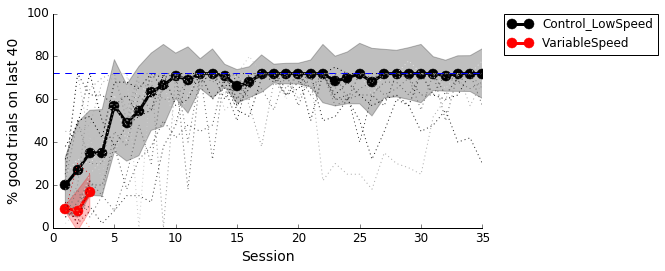

In [75]:
#Redefine Groups used in Option D
#For each group, you need to define ("name": (cm.colorMap, "color for the mean", [list of animal]))

TaskParamToPlot=["% good trials on last 40"]
allResults,colors,colorGroup=plot_mean_subgroup_animal(root,groups,param,stop_date,tagList,redo=False,TaskParamToPlot=TaskParamToPlot)
#save plot
path=os.path.join(root,"Analysis")
if not os.path.exists(path):
    os.mkdir(path)
s1 =""
for r in group1:s1=s1+r
s2 =""
for r in group2:s2=s2+r
#pathFig=os.path.join(path,"LearningAcrossSessionForAnimals_s1_versus_s2.png")
#pathFig=os.path.join(path,"LearningAcrossSessionForAnimals_Control_LowSpeedVsHighSpeed.png")
pathFig=os.path.join(path,"LearningAcrossSessionForAnimals_95_100.png")
plt.savefig(pathFig,format="png")


## 3. Compare phases (sessions tags)

In [ ]:
#animalList=["Rat043","Rat044","Rat045","Rat046","Rat051","Rat056","Rat058","Rat060","Rat063","Rat066","Rat065"]
animalList=["Rat070","Rat071","Rat072","Rat074","Rat075"]
stop_date=""
tagList=["BeforeBreak","AfterBreak","AfterLesion"]
variablestocompare=["Forward Speed","Trajectory Correlation good trials","treadmillSpeed","% good trials"]
_=compareDifferentPhases_AllSessions(root,animalList,variablestocompare,param,stop_date,tagList,redo=False)

#path=os.path.join(root,"Analysis")
#pathFig=os.path.join(path,"Phases_TestForM1Lesion_41.svg")
#plt.savefig(pathFig,format="svg")


# 4- Compare two groups Wilcoxon

In [ ]:
#animalList =["Rat041","Rat042","Rat047","Rat057","Rat059","Rat061","Rat062","Rat067","Rat068"]
#animalList =["Rat045","Rat046","Rat051"]#same speed
#animalList =["Rat043","Rat044","Rat056","Rat058","Rat060","Rat063","Rat066","Rat065"]#decrease treadmillSpeed
#animalList =["Rat062","Rat067","Rat068"]
#animalList = ["Rat041","Rat042","Rat068","Rat062","Rat061","Rat059"]#DLS LESION
animalList = ["Rat041","Rat042","Rat059"]
#animalList = ["Rat043","Rat044","Rat056","Rat058","Rat060","Rat063","Rat066","Rat065"]#M1 LESION
#animalList = ["Rat051","Rat045","Rat046"]#M1 LESION
variablestocompare =["Forward Speed","Trajectory Correlation","treadmillSpeed"]
stop_date = ""
tag1 = "AfterBreak"
tag2 = "AfterLesion"
medianallResults1,medianallResults2=compareTwoPhases_Wilcoxon(root,animalList,variablestocompare,tag1,tag2,param,stop_date,redo=False)

path=os.path.join(root,"Analysis")
#pathFig=os.path.join(path,"WilcoxonTestForDLSLesion_51_46.svg")
#plt.savefig(pathFig,format="svg")
